In [1]:
# import test_tensor_2d as tt ttbd
import quimb as qu
import quimb.tensor as qtn
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import itertools
import utils.dk_lattice_geometry as dq
import utils.exact_jwt
import stabilizers as stab
import qubit_networks as beeky ###
from itertools import product, starmap
import autoray
import scipy.sparse as sparse
import functools
import assorted_conts as ac
from quimb.utils import pairwise

%matplotlib inline

In [264]:
reload(beeky)
T_, V_, MU_ = 1.0, 1.0, 2.0
qlat = dq.SpinlessHub(Lx=2, Ly=3)
mpoham = beeky.MPOSpinlessHam(qlat, T_, V_, MU_)
simham = beeky.SpinlessSimHam(qlat, T_, V_, MU_)

qnet = beeky.QubitEncodeVector.rand(qlat)
# mpo146 = mpoham._ham_terms[(1,4,6)]

# t0=qnet.apply_mpo(mpo=mpo146, where=(0,3,6), contract=True)


In [5]:
reload(dq)

##Testing params
T_PARAM=1
V_PARAM=2
MU_PARAM=0
LX, LY = 2, 3


### Exact Hubbard Hamiltonian
hub = exactJWT.HubbardSpinless(Lx=LX, Ly=LY)
hub.build_spinless_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
Hexact = hub._Ham.copy()
gex, gsx = qu.eigh(Hexact)
print(f'Exact: {gex[0:3]}')

# nx = hub.state_occs(state=gsx[:,0])
# print(nx,end='\n\n')


### Qubit lattice Hamiltonian
sql = dq.SpinlessHub(Lx=LX,Ly=LY)
sql.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
simHam = sql.ham_sim()
sens, seigst = qu.eigh(simHam)
print(f'Nonstable: {sens[0:3]}')

sql.make_stabilizer()
codeHam = sql.ham_code()
rens, reigst = qu.eigh(codeHam)
print(f'Stable: {rens[0:3]}')

# print(sql.state_local_occs(k=None, qstate=Uplus@reigst[:,0]))

Exact: [-3.06118188 -2.41421356 -2.27945232]
Nonstable: [-3.18711224 -3.06118188 -2.41421356]
Stable: [-3.06118188 -2.41421356 -2.27945232]


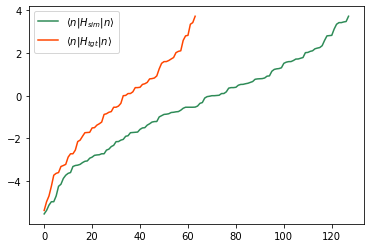

In [148]:
plt.plot(sens, label=r'$\langle n|H_{sim}|n\rangle$', color='seagreen')
plt.plot(rens, label=r'$\langle n|H_{tgt}|n\rangle$', color='orangered')
plt.legend()

***
**Imaginary time evolution**
***

Examine how changing the time-evolution Hamiltonian from the qubit Hamiltonian $H_{sim}$ to the "effective error-correcting" Hamiltonian $H_{master} = H_{sim} + H_{stab}$ changes the results.

* $H_{sim}$ has non-fermionic eigenstates, so imaginary-time evolution takes us out of the stable subspace and gives a "fake" non-fermionic ground state.

* $H_{master}$ includes a term to "incentivize" overlap with the stable subspace, which the imaginary-time evolution in the direction of the stable (fermionic) part of the Hilbert space.


In [17]:
reload(beeky)
reload(dq)

T_PARAM=1.0
V_PARAM=1.26
MU_PARAM=0.9

qlat = dq.SpinlessHub(Lx=2,Ly=3)
qlat.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
simHam = qlat.ham_sim()
sens, seigst = qu.eigh(simHam)
print(f'Nonstable: {sens[0:3]}')

qlat.make_stabilizer()
codeHam = qlat.ham_code()
rens, reigst = qu.eigh(codeHam)
print(f'Stable: {rens[0:3]}')

HSIM = beeky.SpinlessSimHam(Lx=2, Ly=3, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
HSTAB = beeky.HamStab(Lx=2, Ly=3)
HMASTER = beeky.MasterHam(HSIM, HSTAB)

tensors = beeky.make_random_net(Lx=2, Ly=3, phys_dim=2)
net1 = beeky.QubitEncodeVector(tensors.copy(), Lx=2, Ly=3,)
net2 = beeky.QubitEncodeVector(tensors.copy(), Lx=2, Ly=3,)
net3 = beeky.QubitEncodeVector(tensors.copy(), Lx=2, Ly=3,)

psi0 = net1.vec_to_dense()
print('<H(0)>:  ',net1.compute_ham_expec(HSIM, normalize=True))


Nonstable: [-5.53274124 -5.37051838 -5.12289199]
Stable: [-5.37051838 -4.9630457  -4.69530491]
<H(0)>:   (-0.4872534417287318+1.7614723425303386e-17j)


In [18]:
reload(beeky)

comp_fns = {'stab' : functools.partial(beeky.compute_encnet_ham_expec, ham = HSTAB),
            'norm':beeky.compute_encnet_normsquared,
            'sim': functools.partial(beeky.compute_encnet_ham_expec, ham=HSIM)  }

#MASTER evolve (fermionic)
tebd1 = beeky.iTimeTEBD(net1, ham=HMASTER, compute_every=50,compute_extra_fns=comp_fns)

#SIM evolve (non fermionic)
tebd2 = beeky.iTimeTEBD(net2, ham=HSIM, compute_every=50,compute_extra_fns=comp_fns)

#STAB then SIM (should be equiv to MASTER)
tebd3a = beeky.iTimeTEBD(net3, ham=HSTAB, compute_every=50, compute_extra_fns=comp_fns)
tebd3b = beeky.iTimeTEBD(net3, ham=HSIM, compute_every=50, compute_extra_fns=comp_fns)

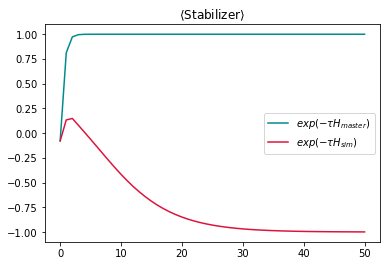

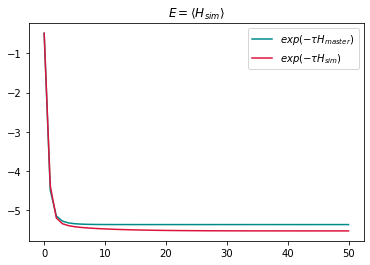

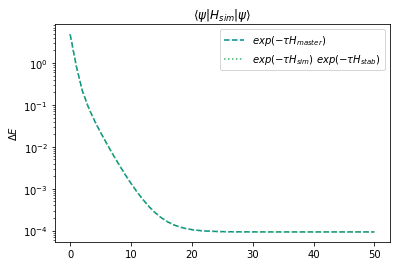

In [22]:
# tebd1.evolve(2500)
# tebd2.evolve(2500)
# tebd3a.evolve(1000)
# tebd3b.evolve(2500)


masterstring = r'$exp(-\tau H_{master})$'
# masterstring = r'$U_{master}(\tau)$'
# simstring = r'$U_{sim}(\tau)$'
simstring = r'$exp(-\tau H_{sim})$'
stabstring = r' $exp(-\tau H_{stab})$'

# seqstring = r'$U_{sim}(\tau)$ $U_{stab}(T)$'

strs = {'master' : masterstring,
          'sim' : simstring,
          'seq' : simstring+stabstring
          }
colormap = {'master':'darkcyan',
            'sim' : 'crimson',
            'seq' : 'mediumseagreen'}          

# taus1 = tebd1.tau*np.array(tebd1.iters)
# taus2 = tebd2.tau*np.array(tebd1.iters)

plt.plot(-1*tebd1.get_final_data('Estab'),label=strs['master'], color=colormap['master'])
plt.plot(-1*tebd2.get_final_data('Estab'), label=strs['sim'], color=colormap['sim'])
# plt.plot(-tebd3a.get_final_data('Estab'),label=strs['seq'], color=colormap['seq'])
plt.title(r'$\langle$Stabilizer$\rangle$')
plt.legend()
plt.show()


plt.plot(tebd1.get_final_data('Esim'),label=strs['master'], color=colormap['master'])
plt.plot(tebd2.get_final_data('Esim'), label=strs['sim'], color=colormap['sim'])
# plt.plot(tebd3b.get_final_data('Esim'), label=strs['seq'], color=colormap['seq'])
plt.title(r'$E=\langle H_{sim}\rangle$')
plt.legend()
plt.show()



plt.semilogy((tebd1.get_final_data('Esim'))-rens[0],ls='dashed',label=strs['master'], color=colormap['master'])
plt.semilogy(tebd3b.get_final_data('Esim')-rens[0],ls='dotted', label=strs['seq'], color=colormap['seq'])
plt.ylabel(r'$\Delta E$')
# plt.hlines(y=rens[0], xmin=0, xmax=taus[-1], ls='dashed', colors='k')
plt.title(r'$\langle\psi|H_{sim}|\psi\rangle$')
plt.legend()
plt.show()




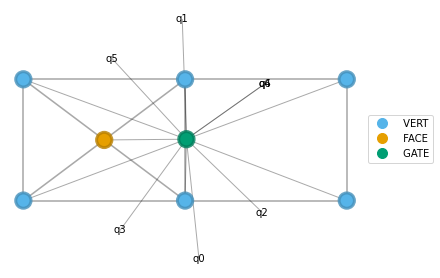

In [25]:
net3.graph()

In [36]:
reload(stab)
reload(dq)

qlat = dq.SpinlessDense(Lx=2,Ly=3)
# code_dims = [2]*6
# sim_dims = [2]*7
U, Udag = stab.one_qubit_U_matrices(qlat, (0,1))
qlat.loop_stabilizer_data(0,1)

{'inds': (1, 2, 5, 4, 6), 'opstring': 'ZZZZX'}

***
**Local Product States**
***
Use `QubitEncodeVector.rand_local_product_state` to make a "local product state" where the vertex-face squares are internally entangled, but unentangled with the rest of the network. 

Right now the "product" bonds (i.e. zero entanglement bonds) are padded with zeros up to `d=2`, while the entangled bonds take `d=bond_dim`.

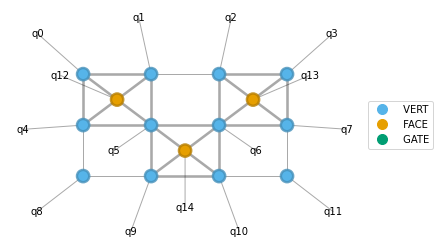

In [3]:
qvec = beeky.QubitEncodeVector.rand_local_product_state(Lx=3, Ly=4, bond_dim=6)
qvec.graph()

Now we want to test the norm contraction $\langle \psi|\psi\rangle$ for local product state (LPS) wavefunctions, which should have weaker entanglement compared to *random* wavefunctions.

In [12]:
reload(beeky)
LX, LY = (3, 4)
D_bond = 3

#medium entanglement
psi_lps = beeky.QubitEncodeVector.rand_local_product_state(Lx=LX, Ly=LY, bond_dim=D_bond)

#high entanglement
psi_rnd = beeky.QubitEncodeVector.rand(Lx=LX, Ly=LY, bond_dim=D_bond)

#make norm and rotate face tensors, since we are going to do BMPS
norm_lps = psi_lps.make_norm().setup_bmps_contraction_(layer_tags=('BRA', 'KET'))
norm_rnd = psi_rnd.make_norm().setup_bmps_contraction_(layer_tags=('BRA', 'KET'))

results = {'exact_lps': norm_lps^all, 'exact_rnd': norm_rnd^all, 'approx_lps':[], 'approx_rnd':[]}

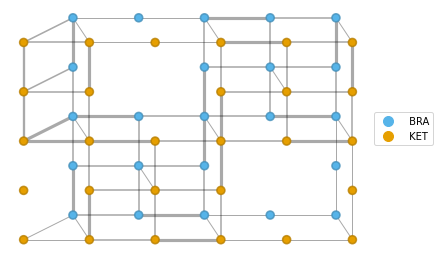

In [13]:
norm_lps.contract_boundary_from_left(xrange=(0,4), yrange=(0,1), layer_tags=('BRA', 'KET'), max_bond=5).graph_layers(color=("BRA", 'KET'))

In [14]:
for chi in range(2, 86, 2):
    nlps = norm_lps.contract_boundary(sequence=['b'], layer_tags=('BRA', 'KET'), max_bond=chi)
    results['approx_lps'].append((chi, nlps))
    nrnd = norm_rnd.contract_boundary(sequence=['b'], layer_tags=('BRA', 'KET'), max_bond=chi)
    results['approx_rnd'].append((chi, nrnd))

Text(0.5, 1.0, 'Initial $D=3$, $L_x, L_y = (3, 4)$')

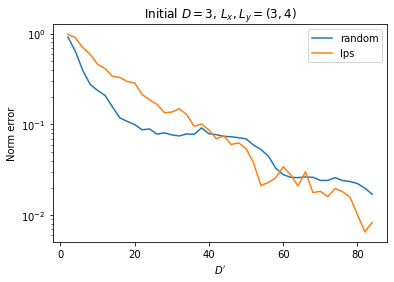

In [16]:
errs = dict({'psi_random': [], 'psi_lps': []})

for (chi, nrnd) in results['approx_rnd']:
    error = abs(1 - nrnd/results['exact_rnd'])
    errs['psi_random'].append((chi, error))
for (chi, nlps) in results['approx_lps']:
    error = abs(1 - nlps/results['exact_lps'])
    errs['psi_lps'].append((chi, error))
plt.semilogy(*zip(*errs['psi_random']), label='random')
plt.semilogy(*zip(*errs['psi_lps']), label='lps')
plt.legend()
plt.ylabel('Norm error')
plt.xlabel("$D'$")
plt.title(f"Initial $D={D_bond}$,  $L_x, L_y = {LX, LY}$")
# plt.title(f'$D={D_bond}$')

Hmm. So not that big a difference.

***
**Applying stabilizers to a qubit state**
***
The stabilizers for a lattice of shape `(Lx, Ly)` are encoded in `HamStab(Lx, Ly).gen_ham_stabilizer_lists()`, which yields pairs like *(integer qubits to act on, ordered 1-qubit gates)*

In [88]:
Lx_, Ly_ = 3, 3
Hstab = beeky.HamStab(Lx=Lx_, Ly=Ly_)

for k, (qubits, gates) in enumerate(Hstab.gen_ham_stabilizer_lists()):
    print(f"Stabilizer {k} acts on qubits ", qubits)

Stabilizer 0 acts on qubits  (1, 2, 5, 4, 10, 9)
Stabilizer 1 acts on qubits  (3, 4, 7, 6, 9, 10)


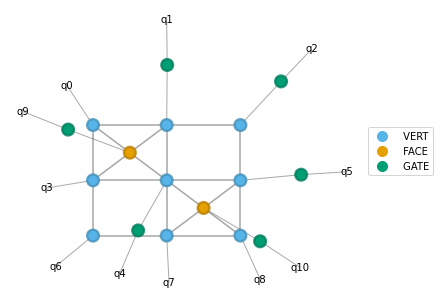

In [89]:
# pick the first stabilizer
S1 = list(Hstab.gen_ham_stabilizer_lists())[0] 

#apply it to a state
psi = beeky.QubitEncodeVector.rand(Lx_, Ly_)

psi.apply_stabilizer(qubits=S1[0], gates=S1[1], inplace=False, contract=False).graph()

We can see that the first stabilizer is centered in the upper-right "face" site, and acts on 4 corners + 2 adjacent faces.

Applying stabilizers and contracting in-place (easy since a stabilizer is a product operator of one-site gates) makes it simple to efficiently compute the expectations $\langle\psi|S|\psi\rangle$.

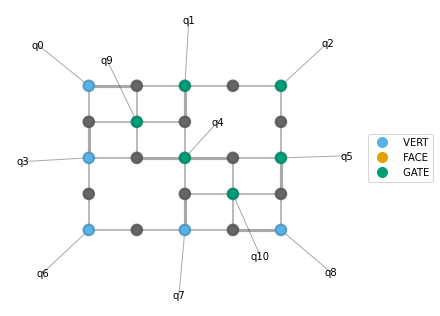

In [92]:
S = next(Hstab.gen_ham_stabilizer_lists())
psi.setup_bmps_contraction().apply_stabilizer(qubits=S[0], gates=S[1], contract=True).graph()

In [94]:
# import sys
# sys.path.insert(1, './tests')
# import tests
Hstab = beeky.HamStab(Lx=Lx_, Ly=Ly_)

# psi = beeky.QubitEncodeVector.rand(Lx_, Ly_)
psi = beeky.QubitEncodeVector.rand_product_state(Lx_, Ly_)

# Compute stabilizer expecations both explicitly and 
# using compute_stabilizer_expec()
tests.compare_stabilizer_expecs(psi=psi, Hstab=Hstab, get_expecs=True)

array([0., 0.])


For lattice size $>2\times 3$, we get stabilizer expectation $\langle\psi|S|\psi\rangle=$  flat 0, so let's try this with a ground state (not random). Try TEBD?

In [2]:
reload(beeky)

T_PARAM=1.0
V_PARAM=1.2
MU_PARAM=0

LX, LY = (3, 3) 

# Encoded Hubbard Hamiltonian 
HSIM = beeky.SpinlessSimHam(Lx=LX, Ly=LY, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
# Stabilizers 
HSTAB = beeky.HamStab(Lx=LX, Ly=LY)
# Hsim + Hstab
HMASTER = beeky.MasterHam(HSIM, HSTAB)


comp_fns = {'stab' : functools.partial(beeky.compute_encnet_ham_expec, ham = HSTAB),
            'norm':beeky.compute_encnet_normsquared,
            'sim': functools.partial(beeky.compute_encnet_ham_expec, ham=HSIM)}


In [3]:
#random state (highly entangled)
net1 = beeky.QubitEncodeVector.rand(Lx=LX, Ly=LY, bond_dim=3)

#Stabilizer evolve (just seek fermionic codespace)
tebd1 = beeky.iTimeTEBD(net1, ham=HSTAB, compute_every=50,compute_extra_fns=comp_fns)


In [4]:
# product state
net2 = beeky.QubitEncodeVector.rand_local_product_state(LX, LY)

tebd2 = beeky.iTimeTEBD(net2, ham=HSTAB, compute_every=50,compute_extra_fns=comp_fns)

In [5]:
tebd1.evolve(500)

n=450, tau=0.01, energy~-2.000000: 100%|██████████| 500/500 [00:43<00:00, 11.45it/s]


In [6]:
tebd2.evolve(500)

n=450, tau=0.01, energy~-2.000000: 100%|██████████| 500/500 [00:24<00:00, 20.29it/s]


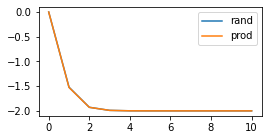

In [7]:
plt.figure(figsize=(4,2))
plt.plot(tebd1.get_normalized_data('Estab'), label='rand')
plt.plot(tebd2.get_normalized_data('Estab'), label='prod')
plt.legend()

We converge quickly to the codespace. 

Note that the stabilizer expectation value is $-2$ because there are two stabilizers on the $3\times 3$ lattice. 
And minus rather than plus because `Hstab` multiplies the stabilizers `*-1` by default (so that the codespace becomes the low-energy $-1$ eigenspace)

Now let's see how the 'stability' (short for 'stabilizer expectation value') evolves when we do iTEBD using the Hubbard Hamiltonian.

In [30]:
Stest = next(HSTAB.gen_ham_stabilizer_lists())
net1.compute_stabilizer_expec(qubits=Stest[0], gates=Stest[1])

In [99]:
net1.setup_bmps_contraction_()
norm= net1.make_norm() ^ all

E_Hstab = net1.compute_ham_expec(HSTAB)

Expec_stab = 0
for S in HSTAB.gen_ham_stabilizer_lists():
    Expec_stab += net1.compute_stabilizer_expec(qubits = S[0], gates = S[1], setup_bmps=False, norm=norm)
    
# print(tebd1.get_normalized_data('Estab'))
# plt.plot(tebd1.get_normalized_data('Estab'))

***
Since custom TEBD/SU/FU code may be unnecessary given Johnny's 2D TN code, maybe write method to convert a `QubitEncodeVector` to a `qtn.TensorNetwork2D`
***

In [29]:
reload(beeky)
psi = beeky.QubitEncodeVector.rand(2,3)
psi_new = psi.convert_to_tensor_network_2d(dummy_size=2, insert_vector_inds=False)

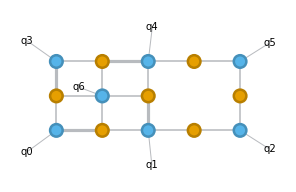

In [194]:
psi.setup_bmps_contraction().graph(color=['QUBIT','AUX'], figsize=(4,4), legend=False)

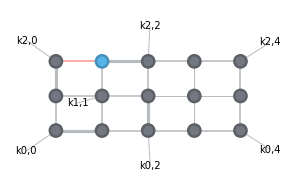

In [24]:
psi_new.graph(color=['S2,1'], figsize=(4,4), legend=False, highlight_inds=psi_new['S2,1'].inds[2])

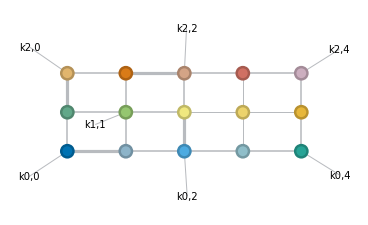

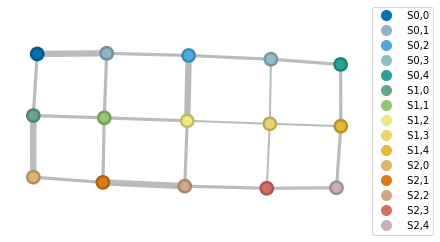

In [30]:
reload(beeky)
epeps = beeky.ePEPS(psi_new, Lx=3, Ly=5)
#epeps = psi.convert_to_ePEPS(dummy_size=2).draw(3)
norm = (epeps & epeps.H).flatten_()

epeps.draw(figsize=(5,5), color=epeps.site_tags, legend=0)
norm.draw(color=epeps.site_tags, show_tags=0)

(6.4907284194489465-8.785394470685879e-16j)


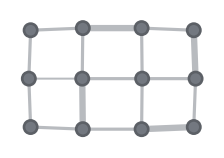

In [172]:
print(norm.contract_boundary())
norm.contract_boundary(around=[(1,2), (1,1)]).draw(figsize=(3,3), show_tags=0)

In [17]:
epeps._EXTRA_PROPS

('_Lx', '_Ly', '_site_tag_id', '_site_ind_id', '_row_tag_id', '_col_tag_id')

**NOTICE** 

If instead of constructing an `ePEPS` directly we tried to use `view_as`, we would need to specify `Lx`, `Ly`, and `site_tag_id="S{},{}"` because we are switching conventions! (if `view_as` tried to gather the attribute from `psi_new`, it would get the wrong lattice size, and `site_tag_id="Q{}"`)

In [53]:
psi_new.view_as(beeky.ePEPS, site_tag_id='S{},{}', site_ind_id='k{},{}')
## Notice the lattice size is (3, 3) rather than (5, 5), because it inherits the attributes from `psi_new`.

<ePEPS(tensors=25, indices=51, Lx=3, Ly=3, max_bond=9)>

***
Wrapping Hamiltonians into instances of `CoordinateHamiltonian`. 

Want to change keys from qubit numbers `(i,j,f)` to lattice coordinates `((xi,yi), (xj,yj), (xf,yf))`
***

In [138]:
reload(beeky)
psi = beeky.QubitEncodeVector.rand(3, 3)
Hsim = beeky.SpinlessSimHam(Lx=3, Ly=3)
CooHam = Hsim.convert_to_coordinate_ham(psi.qubit_to_coo_map)

In [30]:
print(list(Hsim._ham_terms.keys())[0], ' --> ',
list(CooHam._coo_ham_terms.keys())[0])

(1, 4, 9)  -->  ((0, 2), (2, 2), (1, 1))


***
Splitting two- and three- site gates
***

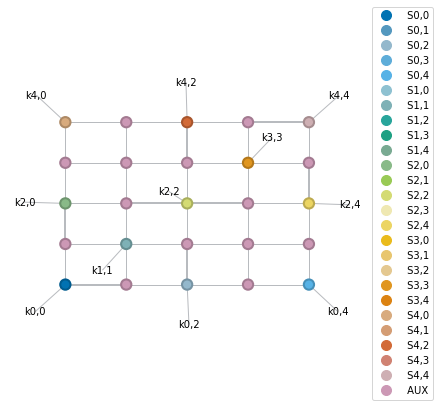

In [59]:
reload(beeky)
epeps = beeky.QubitEncodeVector.rand(3, 3).convert_to_ePEPS(dummy_size=2) #dummy_size=2 for visualization
epeps.draw(color=(*epeps.site_tags, 'AUX'))

In [22]:
reload(beeky)
psi_original = beeky.QubitEncodeVector.rand(3, 3, dtype='float32', bond_dim=3)
gsrs_method = qtn.tensor_2d.gate_string_reduce_split_
X, Y, Z = (qu.pauli(i) for i in 'xyz')
# epeps = beeky.QubitEncodeVector.rand(3, 3).convert_to_ePEPS()

# choose trial gate + tgt qubits
where = (3, 4) #which qubits to act on
numsites = len(where) 
dp = 2 #phys ind dimension
gate = X & X
#**

## take over from here ##
psi = psi_original.copy()
g_xx = qtn.tensor_1d.maybe_factor_gate_into_tensor(gate, dp, numsites, where) #shape (2,2,2,2) or (2,2,2,2,2,2)


site_inds = [psi.phys_ind_id.format(q) for q in where]
bond_inds = [qtn.rand_uuid() for _ in range(numsites)]
reindex_map = dict(zip(site_inds, bond_inds))

TG = qtn.Tensor(g_xx, inds=site_inds+bond_inds, left_inds=bond_inds, tags=['GATE'])

original_ts = [psi[q] for q in where]
bonds_along = [next(iter(qtn.bonds(t1, t2))) for t1, t2 in qu.utils.pairwise(original_ts)]

gss_opts = {'TG' : TG, 
            'where' : where, 
            'string': where,
            'original_ts' : original_ts,
            'bonds_along' : bonds_along,
            'reindex_map' : reindex_map,
            'site_ix' : site_inds,
            'info' : None}

string = where
site_ix = site_inds
info = None
compress_opts = {'absorb': 'right'}

In [46]:
Gpsi0 = psi_original.apply_gate(g_xx, where, contract=False)
Gpsi1 = psi_original.apply_gate(g_xx, where, contract=True)

# Gpsi_2 = psi.apply_gate(g_xx, where, contract='split')
# Gpsi_3 = psi.apply_gate(g_xx, where, contract='reduce_split')


In [17]:
# Gpsi_0.graph()
# psi.graph()
# print(Gpsi_0.vec_to_dense().H @ psi.vec_to_dense())

Why do the 'GATE' tags not show up on the network when we use `contract='split'`?

***
### Absorb 3-body gate into triangle of tensors
***

In [67]:
reload(beeky)
from quimb.tensor.tensor_2d import bonds
import three_body_op as tbo
reload(tbo)

psi = beeky.QubitEncodeVector.rand(3, 3, bond_dim=3)
psi0, psi1 = psi.copy(), psi.copy()
X, Y, Z = (qu.pauli(i) for i in 'xyz')

where = (3, 4, 9) #qubits to act on
gate = X & X & X
# gate = qu.rand_matrix(8)


# current_bonds = {tuple(bonds(psi[3], psi[9]))[0]: 'bond-q3-q9',
#                  tuple(bonds(psi[9], psi[4]))[0]: 'bond-q9-q4',   
#                  tuple(bonds(psi[4], psi[3]))[0]: 'bond-q4-q3'}
# psi.reindex_(current_bonds)


site_inds = [psi.phys_ind_id.format(q) for q in where]
bond_inds = [qtn.rand_uuid() for _ in range(numsites)]
# bond_inds = ['site-gate-{}'.format(q) for q in where]
reindex_map = dict(zip(site_inds, bond_inds))

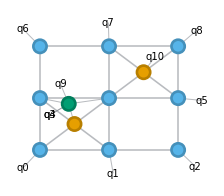

In [68]:
psi.apply_gate(gate, where, contract=False).draw(figsize=(3,4), legend=0)

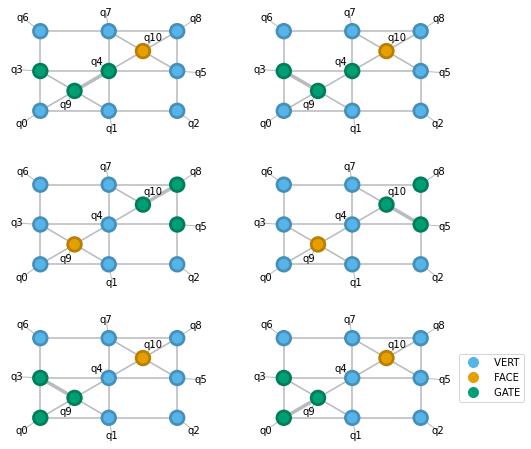

In [91]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,8), subplot_kw={'frame_on':False})
psi.apply_gate(gate, where=(3,4,9), contract='triangle_absorb').draw(ax=ax[0,0])
psi.apply_gate(gate, where=(4,3,9), contract='triangle_absorb').draw(ax=ax[0,1])
psi.apply_gate(gate, where=(5,8,10), contract='triangle_absorb').draw(ax=ax[1,0])
psi.apply_gate(gate, where=(8,5,10), contract='triangle_absorb').draw(ax=ax[1,1])
psi.apply_gate(gate, where=(0,3,9), contract='triangle_absorb').draw(ax=ax[2,0])
psi.apply_gate(gate, where=(3,0,9), contract='triangle_absorb').draw(ax=ax[2,1])

I guess bonds with $d=1$ appear because the applied gate `G = X&X&X` is low rank, so `blob.split` with an SVD leaves only 1 singular value.

What happens if we use QR or LQ instead of SVD?

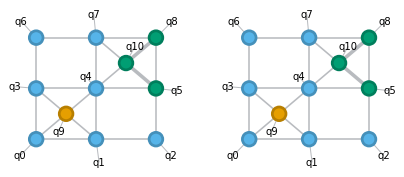

In [62]:
_, ax = plt.subplots(ncols=2, figsize=(7,3), subplot_kw={'frame_on':False})
psi.apply_gate(gate, where=(8,5,10), contract='triangle_absorb', method='qr').draw(ax=ax[0], legend=0)
psi.apply_gate_(gate, where=(8,5,10), contract='triangle_absorb', method='lq').draw(ax=ax[1], legend=0)


***
Adopting `triangle_absorb` method for square TNs, i.e. for the `ePEPS` class.
***


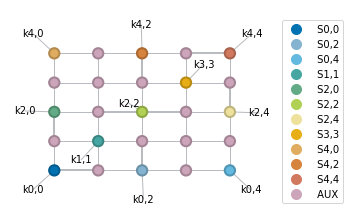

In [5]:
reload(beeky)
epeps = beeky.QubitEncodeVector.rand(3, 3).convert_to_ePEPS(dummy_size=2) 
epeps.draw(color=(*epeps.qubit_site_tags(), 'AUX'), figsize=(5,3))

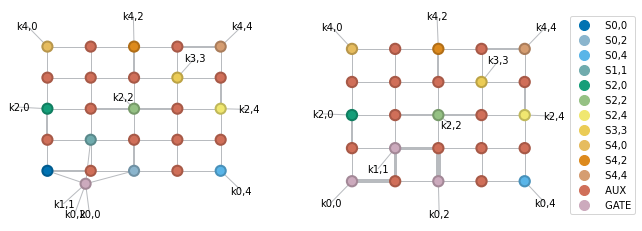

In [6]:
_, ax = plt.subplots(ncols=2, figsize=(10,4), subplot_kw={'frame_on': 0})

where_coos=((0,0), (0,2), (1,1))
epeps.gate(G=qu.rand_matrix(8), coos=where_coos).draw(color=(*epeps.qubit_site_tags(), 'AUX', 'GATE'), ax=ax[0])

# apeps = epeps.absorb_three_body_gate(G=qu.rand_matrix(8), coos=where_coos)
apeps = epeps.gate(G=qu.rand_matrix(8), coos=where_coos, contract='triangle_absorb') 
apeps.draw(color=(*epeps.qubit_site_tags(), 'AUX', 'GATE'), ax=ax[1])


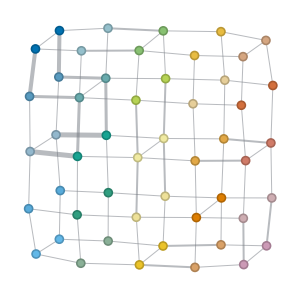

In [24]:
(apeps.H & apeps).draw(color=epeps.site_tags, figsize=(5,4), legend=False)

***
Test 2-body gates on `ePEPS`
***

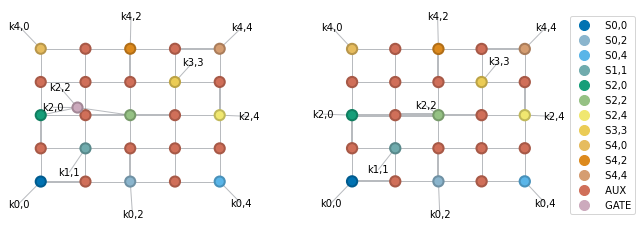

In [13]:
reload(beeky)
_, ax = plt.subplots(ncols=2, figsize=(10,4), subplot_kw={'frame_on': 0})

epeps = beeky.QubitEncodeVector.rand(3, 3).setup_bmps_contraction_().normalize_().convert_to_ePEPS(dummy_size=2) 
tgt_coos = ((2,0), (2,2))
epeps.gate(G=qu.rand_matrix(4), coos=tgt_coos, contract=False).draw(color=(*epeps.qubit_site_tags(), 'AUX', 'GATE'), ax=ax[0])
epeps.gate(G=qu.rand_matrix(4), coos=tgt_coos, contract='reduce_split_lr').draw(color=(*epeps.qubit_site_tags(), 'AUX', 'GATE'), ax=ax[1])

Q: Why does the bond dimension go from 4 to 16?  
A: To apply the 2-body gate we `tensor_split` the gate tensor, e.g. via a QR decomp, which results in `Gl--Gr` connected by a size-4 bond, which is then squished together with the site bonds. So $D\to 4D$.

#### Need to figure out where `'GATE'` tag goes...

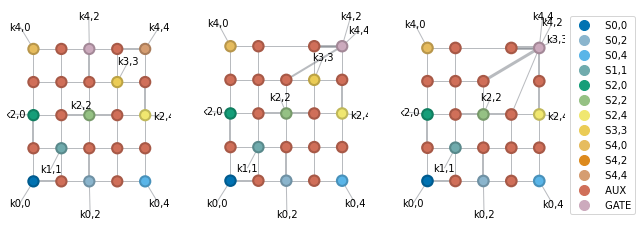

In [171]:
reload(beeky)
_, ax = plt.subplots(ncols=3, figsize=(10,4), subplot_kw={'frame_on': 0})
epeps = beeky.QubitEncodeVector.rand(3, 3).convert_to_ePEPS(dummy_size=2) 

epeps.gate(G=qu.rand_matrix(2), coos=((4,2)), contract=True).draw(color=(*epeps.qubit_site_tags(), 'AUX', 'GATE'), ax=ax[0])
epeps.gate(G=qu.rand_matrix(4), coos=((4,2), (4,4)), contract=True).draw(color=(*epeps.qubit_site_tags(), 'AUX', 'GATE'), ax=ax[1])
epeps.gate(G=qu.rand_matrix(8), coos=((4,2), (4,4), (3,3)), contract=True).draw(color=(*epeps.qubit_site_tags(), 'AUX', 'GATE'), ax=ax[2])


***
Right now `ePEPS` subclasses `quimb.TensorNetwork2DFlat` but not `quimb.TensorNetwork2DVector`, because I feel weird about adding fake physical indices to every "artificial" site.  

If I force the fake indices thing, I can make an `ePEPSvector` to subclass the quimb TN2DVector class, which will inherit things like `compute_local_expectation` and `normalize`.

To do:
- Write `ePEPSvector` class
- Checks:
    - Plaquettes
    - ~~`gate` inheritance~~
    - `compute_local_expectation`!


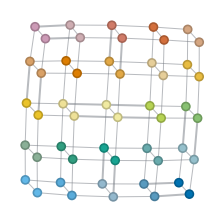

In [172]:
epvec = beeky.QubitEncodeVector.rand(3, 3).convert_to_ePEPS_vector(dummy_size=2)

epvec.make_norm().draw(color=(*epvec.site_tags,), figsize=(3,3), legend=0)

Now to compute Ham expectations!

To do this, we need to modify the 'plaquette' compilation method, bc the quimb `calc_plaquette_sizes` only looks for 2-body interactions but we need 3-body terms as well.

(I already did this for the `QubitEncodeNet` module so we should be able to reuse that code)

In [132]:
q2coo = lambda q: epvec.qubit_to_coo_map[q]

CooHam = beeky.SpinlessSimHam(Lx=3, Ly=3).convert_to_coordinate_ham(q2coo)
ham_terms = CooHam._coo_ham_terms

In [150]:
for coos in ham_terms.keys():
    print(coos)

((0, 2), (2, 2), (1, 1))
((2, 2), (4, 2), (3, 3))
((4, 0), (2, 0))
((4, 4), (2, 4), (3, 3))
((2, 0), (0, 0), (1, 1))
((2, 4), (0, 4))
((2, 0), (2, 2), (1, 1))
((2, 2), (2, 4), (3, 3))
((0, 4), (0, 2))
((0, 2), (0, 0), (1, 1))
((4, 4), (4, 2), (3, 3))
((4, 2), (4, 0))


In [240]:
reload(beeky)
epvec = beeky.QubitEncodeVector.rand(3, 3).convert_to_ePEPS_vector(dummy_size=2)

envs, plaqmap = epvec.calc_plaquette_envs_and_map(terms=ham_terms)

In [151]:
epvec.compute_local_expectation(terms=ham_terms, normalized=True, plaquette_envs=envs, plaquette_map=plaqmap)

(0.17894589173499517-6.68673888017301e-16j)

WHOA. Now for some pretty `envs` drawings.

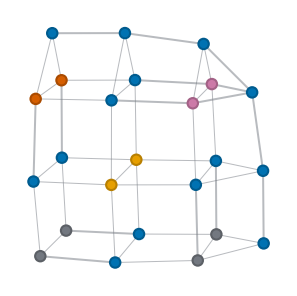

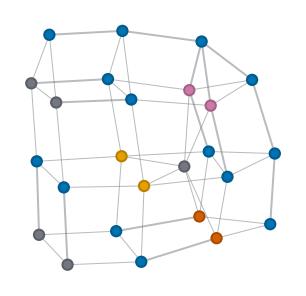

In [135]:
norm, bra, ket = epvec.make_norm(return_all=True)

where, G = list(ham_terms.items())[6] # choose some term
p = plaqmap[where]
sites = tuple(starmap(ket.site_tag, qtn.tensor_2d.plaquette_to_sites(p)))

ket_local = ket.select_any(sites).view_as_(qtn.tensor_2d.TensorNetwork2DVector, like=epvec)
bra_and_env = bra.select_any(sites) | envs[p]

(ket_local|bra_and_env).draw(color=(*sites,'AUX'), show_inds=0, show_tags=0, figsize=(5,4), legend=0)

(ket_local.gate(G, where, contract=False) | bra_and_env).draw(color=(*sites,'AUX'), show_inds=0, show_tags=0, figsize=(5,4), legend=0)

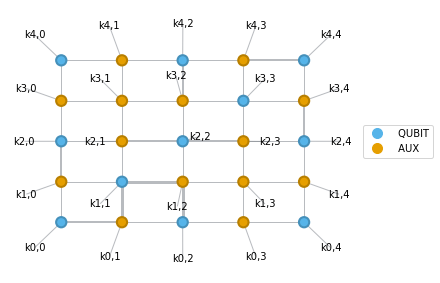

In [236]:
coos = ((0,2),(0,0),(1,1))
epvec.gate(ham_terms[coos], coos, contract='auto_split').draw()

Just realized the `triangle_absorb` methods aren't working properly. Need to keep the bonds on the right tensors!

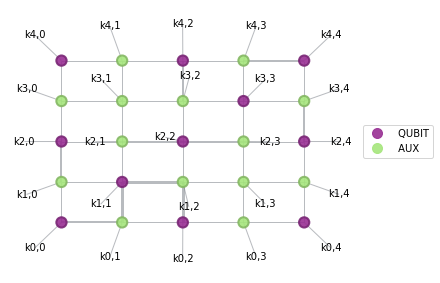

In [11]:
reload(beeky)
evec = beeky.QubitEncodeVector.rand(3, 3).convert_to_ePEPS_vector(dummy_size=2)

gvec = evec.gate(G=qu.rand_matrix(8), coos=((0,0), (0,2), (1,1)), contract='auto_split')
gvec.draw(custom_colors=((0.6, 0.19, 0.58, 0.9),(0.65, 0.9, 0.49, 0.9)))

Try to get TEBD running! Do I need to write my own TEBD class to get 3-body terms allowed?

In [12]:
import hamiltonians as hams
reload(hams)
h = hams.SpinlessSimHam(3, 3).convert_to_coordinate_ham( evec.qubit_to_coo_map)

In [13]:
h.get_gate_expm(where=((4,0), (2,0)), x=0.01)

[[ 1.      +0.j  0.      +0.j  0.      +0.j  0.      +0.j]
 [ 0.      +0.j  0.998385+0.j -0.009979+0.j  0.      +0.j]
 [ 0.      +0.j -0.009979+0.j  0.997553+0.j  0.      +0.j]
 [ 0.      +0.j  0.      +0.j  0.      +0.j  1.00585 +0.j]]

In [2]:
from tebd import qubitTEBD
import hamiltonians as hams

psi0 = beeky.QubitEncodeVector.rand(3, 3).convert_to_ePEPS_vector()
ham = hams.SpinlessSimHam(3,3).convert_to_coordinate_ham(psi0.qubit_to_coo_map)
qtebd = qubitTEBD(psi0, ham)

In [49]:
qtebd.evolve(50)

n=180, tau=0.01, energy~-1.814475:  80%|████████  | 40/50 [03:41<00:55,  5.55s/it]


LinAlgError: Array must not contain infs or NaNs.

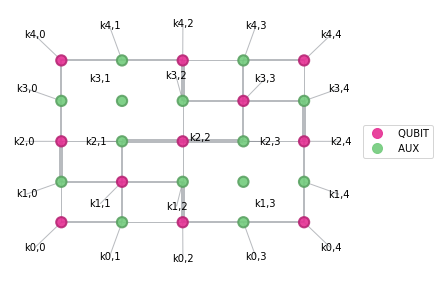

In [20]:
qtebd.state.draw(custom_colors=((0.9, 0.19, 0.58, 0.9),(0.45, 0.8, 0.49, 0.9)))

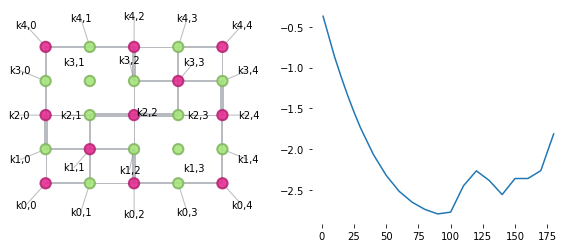

In [51]:
_, ax = plt.subplots(ncols=2, figsize=(10,4), subplot_kw={'frame_on': 0})
qtebd.state.draw(custom_colors=((0.9, 0.19, 0.58, 0.9),(0.65, 0.9, 0.49, 0.9)), figsize=(5,5), ax=ax[0], legend=0)
ax[1].plot(qtebd.its, qtebd.energies)

In [56]:
qtebd.state

<ePEPSvector(tensors=25, indices=65, Lx=5, Ly=5, max_bond=16)>

What the FUCK.

Hopefully the random new index came just from force-stopping the computation. But need to figure out:
- max_bond stuff
- square lattice vs triangle stuff

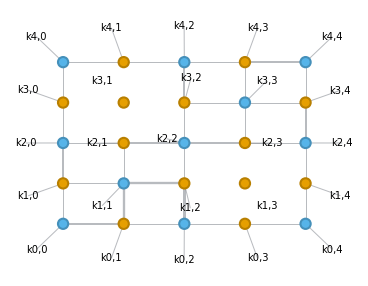

In [38]:
# psi0 = beeky.QubitEncodeVector.rand(3, 3).convert_to_ePEPS_vector()
G, coos=qu.rand_matrix(8), [(0,0),(0,2),(1,1)]
Gpsi = psi0.gate(G, coos, max_bond=5, method='svd')
# Gpsi.gate_(G, coos, max_bond=6, method='lq')
Gpsi.draw(figsize=(5,5), legend=0)

In [43]:
Gpsi.bond_size((0,2), (1,2))

8

The `max_bond` arg for `triangle_gate_absorb` doesn't work as intended. Start by fixing it for `QEV` TNs.

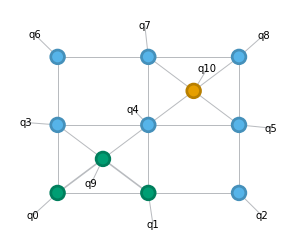

In [19]:
import three_body_op
reload(beeky)
reload(three_body_op)
G, coos=qu.rand_matrix(8), [(0,0),(0,2),(1,1)]
qev = beeky.QubitEncodeVector.rand(3, 3, bond_dim=2)

gate_opts = {'G':G, 'where':coos, 'keys':'coos', 'contract':'triangle_absorb', 'method':'svd',
'max_bond':3}

bndBC0 = qev.bond(9, 1)

Gqev = qev.apply_gate(**gate_opts)
bndBC1 = Gqev.bond(9,1)
Gqev.apply_gate_(**gate_opts)
Gqev.draw(figsize=(4,5), legend=0)


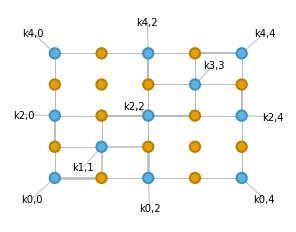

6 3


In [32]:
# epeps = Gqev.convert_to_ePEPS()
epeps.draw(figsize=(4,4), legend=0)
print(epeps.bond_size((0,0), (0,1)), epeps.bond_size((1,1), (0,1)))

In [30]:
print(Gqev.bond_size(0,9), Gqev.bond_size(0,1))

3 2


Figuring out fermionic stability in qTEBD

In [62]:
import hamiltonians as hams
import tebd
reload(tebd)
Lx, Ly = 2,3
psi0 = beeky.QubitEncodeVector.rand(Lx,Ly).convert_to_ePEPS_vector()
ham = hams.SpinlessSimHam(Lx,Ly).convert_to_coordinate_ham(psi0.qubit_to_coo_map)
stab_ham = hams.HamStab(Lx,Ly)
qtebd = tebd.qubitTEBD(psi0, ham, stabilizer_ham=stab_ham, compute_energy_final=False, compute_energy_every=10)

In [63]:
exp = tebd.compute_fermionic_stability(qtebd)

In [80]:
lst = []
lst.extend(exp)

In [78]:
lst

[(0.09469966972502643-5.47655815050315e-17j)]

In [81]:
stab_expecs = []
for epoch in range(5):
    qtebd.evolve(10)
    stab_expecs.extend(tebd.compute_fermionic_stability(qtebd))



  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\gabri\miniconda3\envs\updated_quimb\lib\site-packages\quimb\tensor\tensor_2d_tebd.py:634: ComplexWarning: Casting complex values to real discards the imaginary part
  self.energies.append(float(en))
n=40, tau=0.01, energy~-0.960374: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


C:\Users\gabri\miniconda3\envs\updated_quimb\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


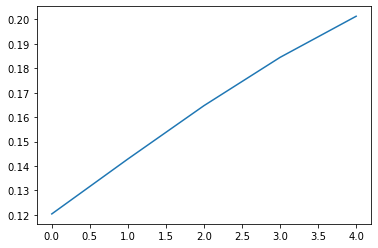

In [88]:
# plt.plot(qtebd.its, qtebd.energies)
plt.plot(stab_expecs)